# Importing libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Import from tensorflow.keras instead of just keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt

# Reading the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Data sets/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

# Visualizing the data

In [4]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

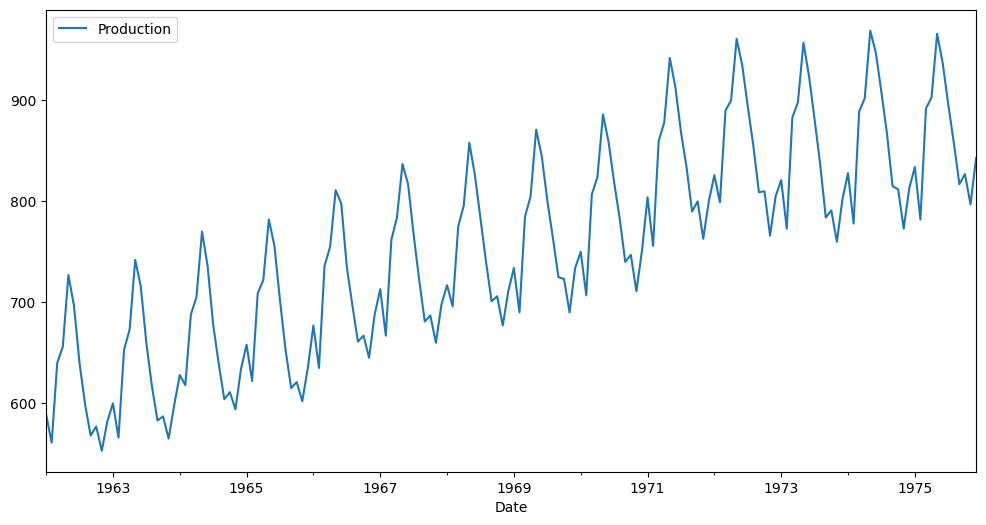

In [5]:
df.plot(figsize=(12,6))

In [6]:
len(df)

168

# Train & test split

In [43]:
train = df.iloc[:156]
test = df.iloc[156:]

# Some necessary preprocessing

In [9]:
scaler = MinMaxScaler()

In [11]:
scaler.fit(df)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

# Turning the data into a time series

In [14]:
# define an input length for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [15]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: 
 [[0.11298077]]


# Defining a deep learning LSTM model

In [55]:
# define model
n_features = 1

model = Sequential()

model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 12, 200)           161600    
                                                                 
 lstm_11 (LSTM)              (None, 12, 200)           320800    
                                                                 
 lstm_12 (LSTM)              (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 803401 (3.06 MB)
Trainable params: 803401 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model training

In [57]:
# training the model
model.fit(generator,epochs=150)

Epoch 1/150
144/144 [==============================] - 11s 44ms/step - loss: 0.0553
Epoch 2/150
144/144 [==============================] - 8s 53ms/step - loss: 0.0291
Epoch 3/150
144/144 [==============================] - 9s 61ms/step - loss: 0.0164
Epoch 4/150
144/144 [==============================] - 7s 45ms/step - loss: 0.0106
Epoch 5/150
144/144 [==============================] - 9s 62ms/step - loss: 0.0115
Epoch 6/150
144/144 [==============================] - 6s 45ms/step - loss: 0.0067
Epoch 7/150
144/144 [==============================] - 8s 55ms/step - loss: 0.0053
Epoch 8/150
144/144 [==============================] - 7s 46ms/step - loss: 0.0044
Epoch 9/150
144/144 [==============================] - 6s 43ms/step - loss: 0.0048
Epoch 10/150
144/144 [==============================] - 9s 61ms/step - loss: 0.0034
Epoch 11/150
144/144 [==============================] - 7s 46ms/step - loss: 0.0039
Epoch 12/150
144/144 [==============================] - 9s 63ms/step - loss: 0.0035


# Testing the model, visuaizing the loss

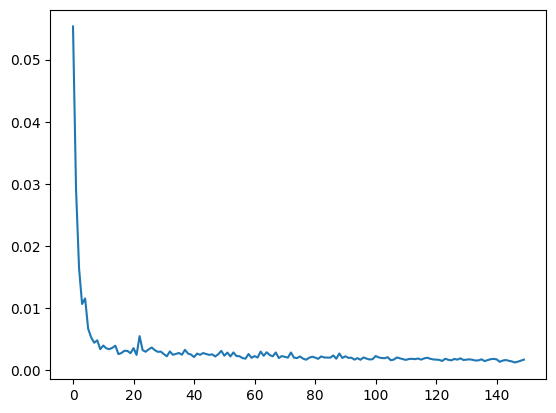

In [58]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 28ms/step


In [60]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[819.52211761],
       [795.64972305],
       [886.68691635],
       [906.04969788],
       [949.11333847],
       [938.26549149],
       [911.39397812],
       [869.26993942],
       [821.71999359],
       [810.19488144],
       [788.17074585],
       [806.01504898]])

In [61]:
test['Predictions'] = true_predictions

<ipython-input-61-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [62]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,819.522118
1975-02-01,782,795.649723
1975-03-01,892,886.686916
1975-04-01,903,906.049698
1975-05-01,966,949.113338


<Axes: xlabel='Date'>

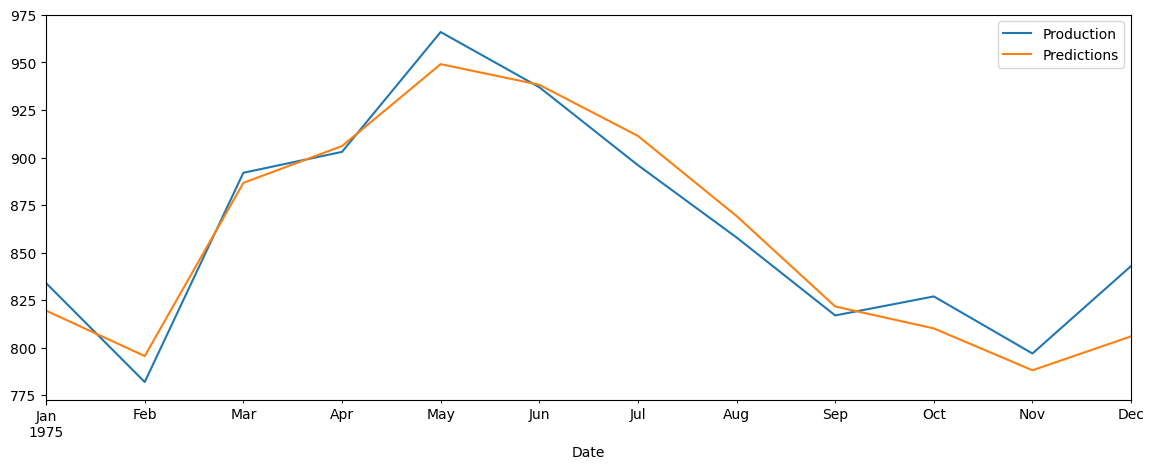

In [63]:
test.plot(figsize=(14,5))

In [65]:
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

15.36970265408562
